# 3D structure tensor - a small example
A small example demonstrating the use of 3D structure tensor for visualizing and clustering dominant orientation. 

In [1]:
%matplotlib notebook
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

import structure_tensor as st

## Reading the data

The data is a small cube from a volumetric image og fibre composite. The cube contains five bundles in layers: UD fibre (0 deg), crossing fibre (45 deg), 90 deg fibre, -45 deg bundle, UD bundle (0 deg).

In [2]:
volume = scipy.io.loadmat('example_data_3D/multi_cube.mat')['vol']
print(volume.shape)

(150, 150, 150)


## Computing the structure tensor and the dominant orientation
Computation of structure tensor requires only two parameters: the noise scale sigma and the integration scale rho. Parameter sigma controls smothing while computing gradientes, and structures smaller than sigma will be removed by smoothing. Parameter rho gives the size over the neighborhood in which the orientation is to be analysed for every volume voxel. Larger rho will result in a smoother orientation field.

Structure tensor is a 3x3 matrix, but as it is symmetrical we only carry values of 6 elements: $s_{xx}$, $s_{yy}$, $s_{zz}$, $s_{xy}$, $s_{xz}$ and $s_{yz}$.

Eigenvalues (val) carry the information about the degree of anisotropy - this is not used or visualized here. Eigenvectors (vec) carry the orientation information, as $x$, $y$, and $z$ component of the orientation vector.

In [3]:
sigma = 0.5; # noise scale
rho = 2; # integration scale
S = st.structure_tensor_3d(volume, sigma, rho)
val, vec = st.eig_special_3d(S)

print(f'The volume has a shape {volume.shape}, i.e. {volume.size} voxels.')
print(f'Structure tensor information is carried in a {S.shape} array.')
print(f'Orientation information is carried in a {vec.shape} array.')

The volume has a shape (150, 150, 150), i.e. 3375000 voxels.
Structure tensor information is carried in a (6, 150, 150, 150) array.
Orientation information is carried in a (3, 150, 150, 150) array.


## Visualizing the dominant orientation
Here we show only dominant orientation, ignoring shape measures. 

Since slicng is in $z$ direction, the arrows show $x$ and $y$ component of orientation vectors, on top of every slice.

In [4]:
def show_vol_flow(V, vec, z, s=5, double_arrow = False):     
    xmesh, ymesh = np.mgrid[0:V.shape[1], 0:V.shape[2]]
    fig, ax = plt.subplots()
    ax.imshow(V[z], cmap=plt.cm.gray)
    g = slice(s//2, None, s)
    ax.quiver(ymesh[g, g], xmesh[g, g], vec[0, z, g, g], vec[1, z, g, g],
              color='r', angles='xy')
    if double_arrow:
        ax.quiver(ymesh[g, g], xmesh[g, g], -vec[0, z, g, g], -vec[1, z, g, g],
              color='r', angles='xy')
    ax.set_title(f'slice z={z}')
    plt.show()

<IPython.core.display.Javascript object>


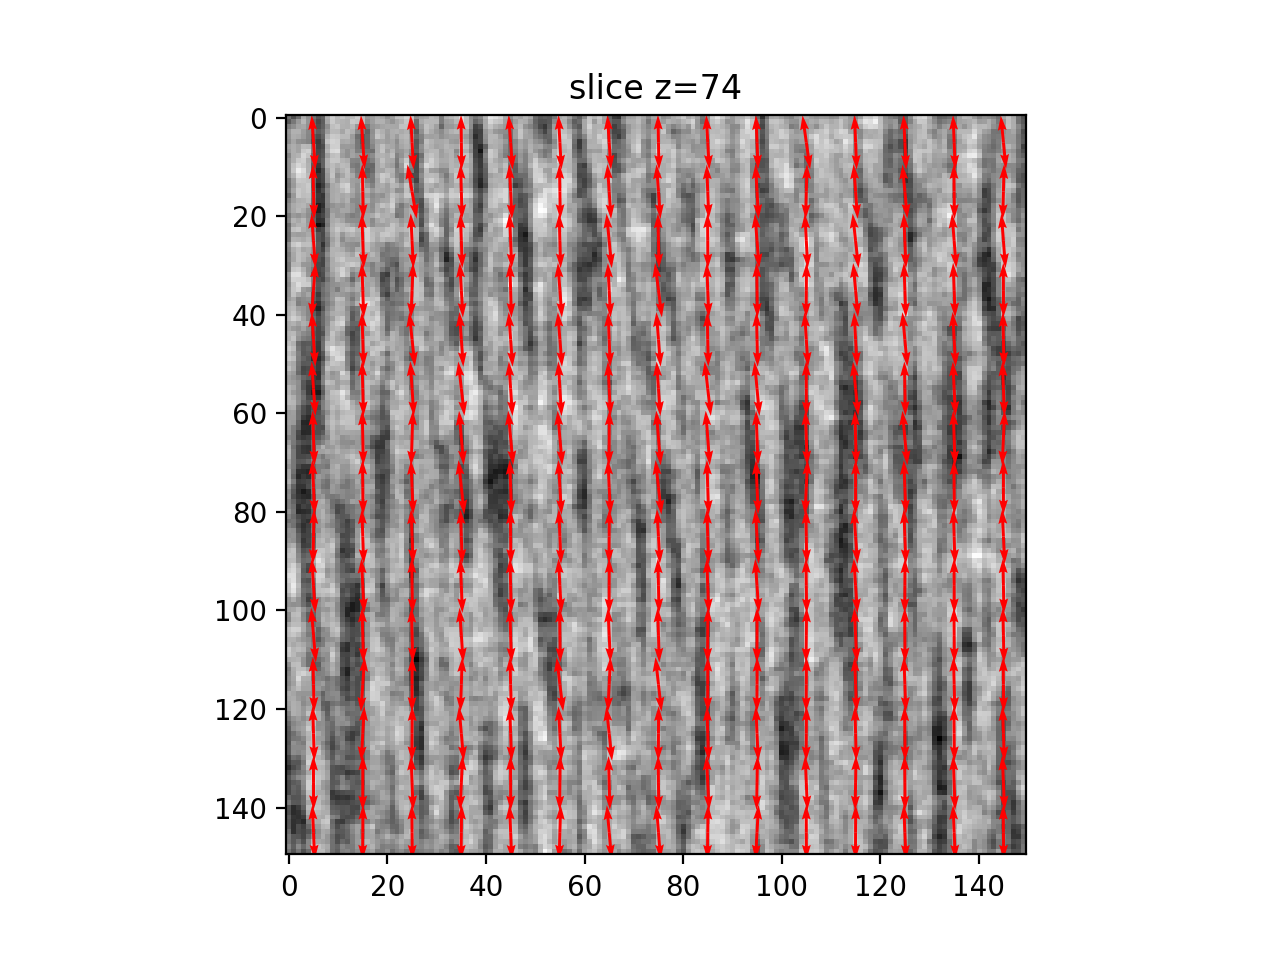

In [5]:
show_vol_flow(volume, vec, z=74, s=10, double_arrow = True) 

When visualizing the orientation as color, I choose fan coloring which uses hsv colors for orientatins in a certain plane, here a $xy$ plane,, and gray color for the orientations orthogonal to this plane. This coloring is convenient since all fibre bundles lay in $xy$ plane.

In [6]:
import scmap

def show_vol_orientation(V, vec, z, coloring = scmap.Ico(), alpha=0.5):

    dim = V.shape[1:]
    vectors = vec[:,z].transpose((1,2,0)).reshape(-1, 3)
    rgb = coloring(vectors).reshape(dim + (3,))
    rgba = np.concatenate((rgb, alpha*np.ones(dim + (1,))), axis=2)
    fig, ax = plt.subplots()
    ax.imshow(V[z])
    ax.imshow(rgba)
    ax.set_title(f'slice z={z}')
    plt.show()

<IPython.core.display.Javascript object>


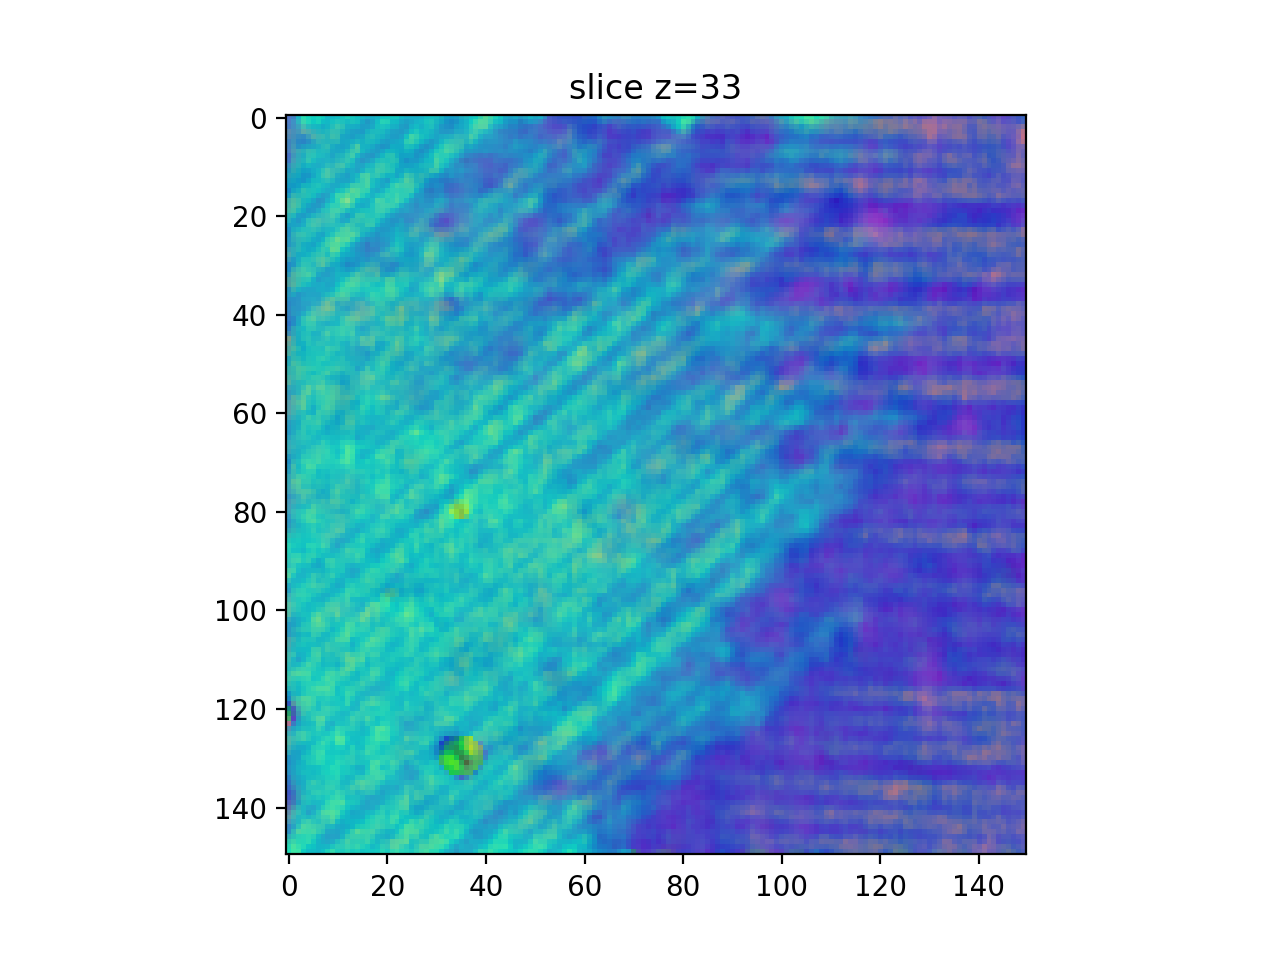

In [7]:
show_vol_orientation(volume, vec, z=33) 

## And again for a rotated sample
The same analysis as above, but for the sample rotated such that layers are in $xz$-plane.

In [8]:
volume = np.transpose(volume, (1, 0, 2))
S = st.structure_tensor_3d(volume, sigma, rho)
val, vec = st.eig_special_3d(S)

<IPython.core.display.Javascript object>


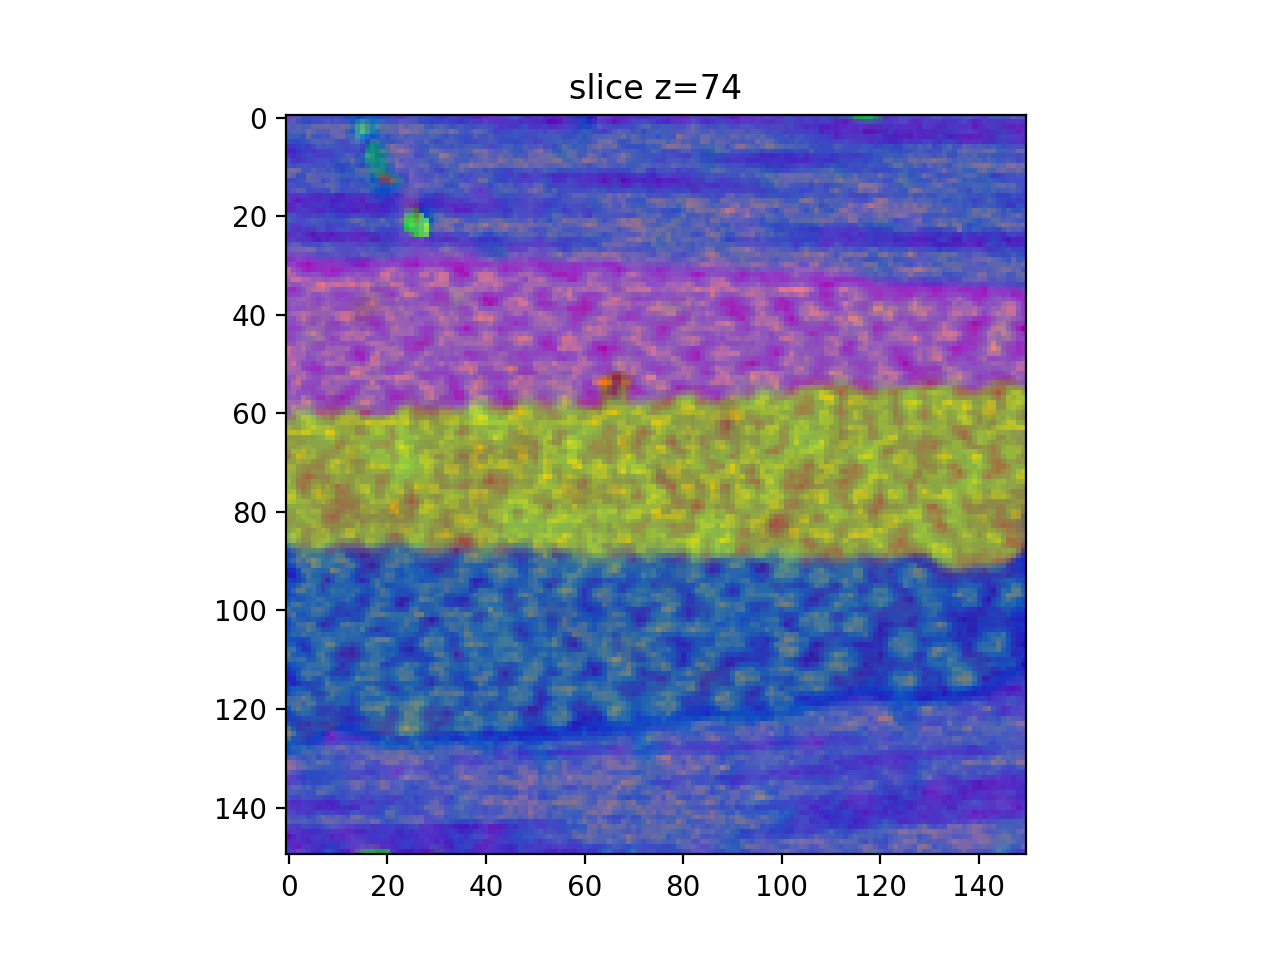

In [9]:
show_vol_orientation(volume, vec, 74)

## Investigating tensor-vector distance
A tensor-vector distance can be computed for every voxel. Here I compute the distance from the z-direction. In the rotated volume, a 90 deg. bundle (the middle layer) is aligned with z-direction, and has the smallest distance.

<IPython.core.display.Javascript object>


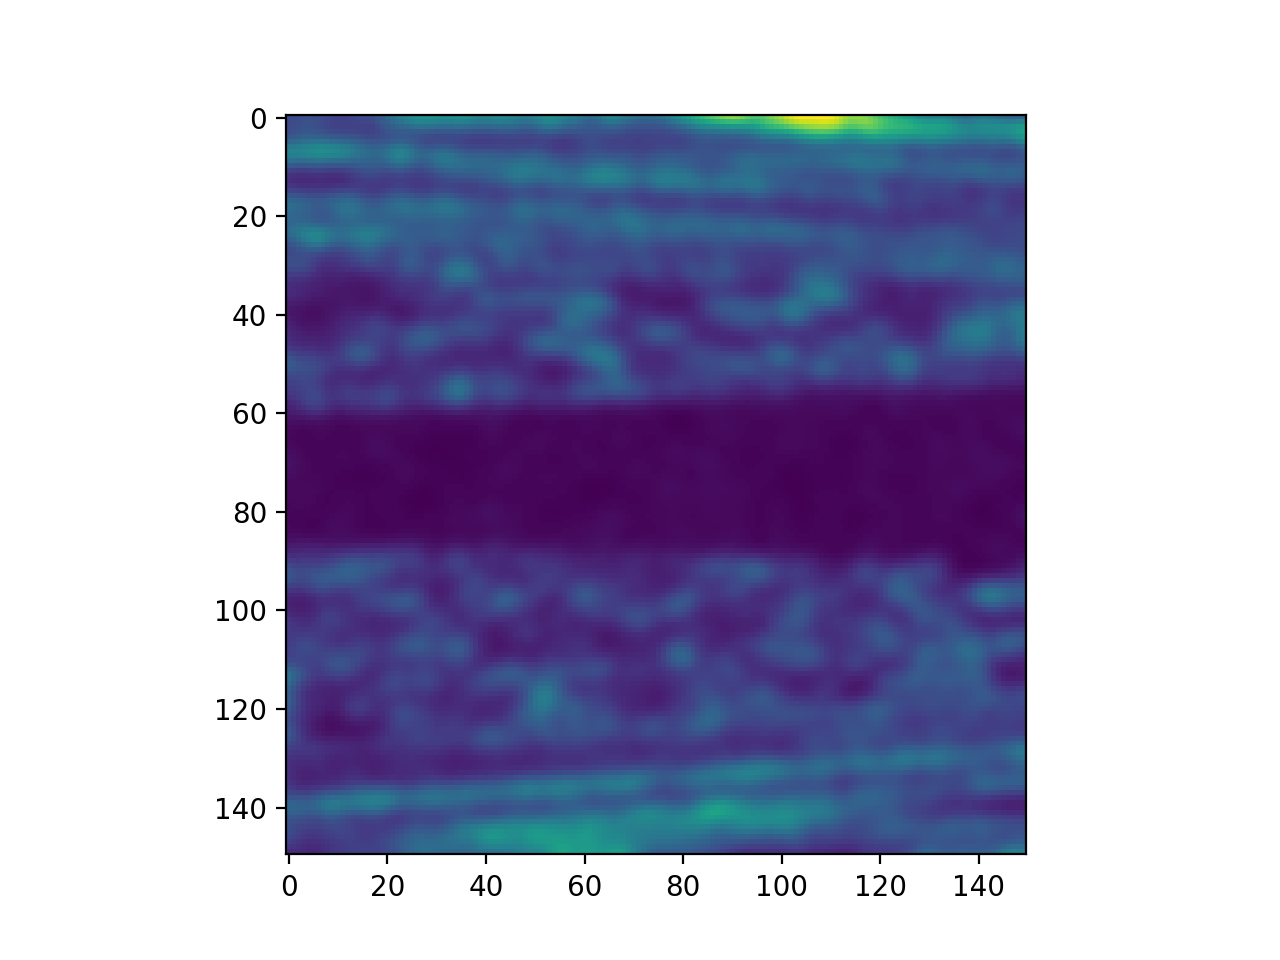

In [10]:
def tensor_vector_distance(S, u):
    dim = S.shape[1:]
    S = S.reshape(6,-1)
    dist = np.dot(S[0:3].T,u**2) + 2*np.dot(S[3:].T,u[[0,0,1]]*u[[1,2,2]])
    return dist.reshape(dim)

fig, ax = plt.subplots()
u = np.array([0,0,1])
dist = tensor_vector_distance(S,u)
plt.imshow(dist[74])
plt.show()

## K-means like clustering of structure tensor using tensor-vector distance
Tensor-vector distance allows clustering tensors using an approach similar to k-means. Here, every cluster is characterized by an orientation vector, and consists of the tensors which have a small distance to this orientation. The advantage of the approach is that it operates on tensors, and does not require their eigendecomposition. Only computation of cluster orientation requires eigendecomposition. 